# Task: Predict Health Insurance Owners' who will be interested in Vehicle Insurance

An insurance company has provided Health Insurance to its customers now they want a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

Before building model, let's explore the dataset and get some insights from data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score
%matplotlib inline

train=pd.read_csv('../input/health-insurance-cross-sell-prediction/train.csv')
#test=pd.read_csv('../input/health-insurance-cross-sell-prediction/test.csv')

print("First five rows of training dataset are:")
train.head()

First five rows of training dataset are:


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Information about columns:

* id  -	Unique ID for the customer
* Gender  -	Gender of the customer
* Age  - 	Age of the customer
* Driving_License  - 	0 : Customer does not have DL, 1 : Customer already has DL
* Region_Code  -	Unique code for the region of the customer
* Previously_Insured  -	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age  -	Age of the Vehicle
* Vehicle_Damage  -  1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium  -	The amount customer needs to pay as premium in the year
* PolicySalesChannel  -	Anonymized Code for the channel of outreaching to the customer ie.,Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage  -	Number of Days, Customer has been associated with the company
* Response  -	1 : Customer is interested, 0 : Customer is not interested


We are given two csv files in this dataset: train and test. For EDA, I will use only train set.

Let's have a look at data types of different columns.

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [3]:
print(f"Train set has {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Missing values are present in data: {train.isnull().sum().any()}")

Train set has 381109 rows and 12 columns.
Missing values are present in data: False


# EDA

Features Response, Driving_License and Previously_Insured are alreadyencoded in data. For EDA purpose, I am converting these into object type for easy understanding in visualizations.

In [4]:
train_eda = train.copy()
cols=['Driving_License','Previously_Insured','Response']
for col in cols:
    train_eda[col] = train_eda[col].map({0:'No',1:'Yes'})

## Target variable: Response

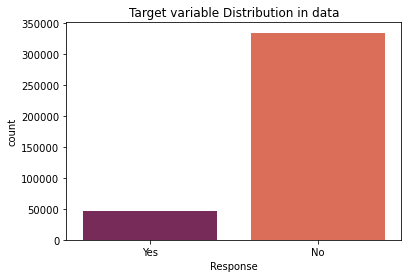

In [5]:
sns.countplot(train_eda['Response'],palette='rocket')
plt.title("Target variable Distribution in data");

* So, our data is highly imbalanced.

> I made two notebooks showing 2 ways to handle imbalanced data. Give them a look:
    [down-sampling-majority-class-6-classification-algo](https://www.kaggle.com/ayushikaushik/down-sampling-majority-class-6-classification-algo)
    and
    [up-sampling-to-tackle-unbalanced-dataset](https://www.kaggle.com/ayushikaushik/up-sampling-to-tackle-unbalanced-dataset)

> [Here](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/) is a good article to understand problems caused by imbalanced article and ways to handle them.

## Gender

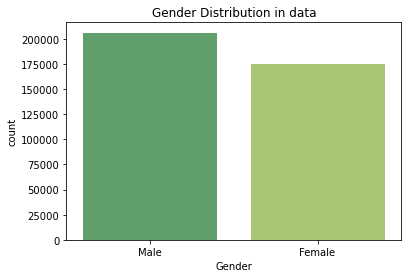

In [6]:
sns.countplot(train_eda['Gender'],palette='summer')
plt.title("Gender Distribution in data");

* There are more samples of gender male.
* Seems as if males are more concerned about health risks.  ;)

## Age

Age distribution according to Response


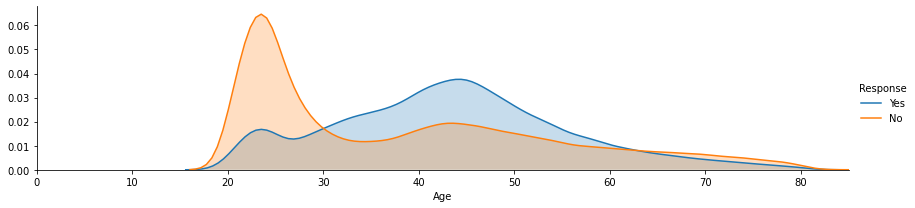

In [7]:
print("Age distribution according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Age",shade = True)
facetgrid.set(xlim = (0,train_eda["Age"].max()))
facetgrid.add_legend();

* Young people below 30 are not interested in vehicle insurance. Reasons could be lack of experience, less maturity level and they don't have expensive vehicles yet.
* People aged between 30-60 are more likely to be interested.

## Driving License

In [8]:
pd.crosstab(train_eda['Response'], train_eda['Driving_License'])

Driving_License,No,Yes
Response,,
No,771,333628
Yes,41,46669


> ***You should always have driving license while driving***

* Here also majority observations have a driving license.


## Region-wise Distribution

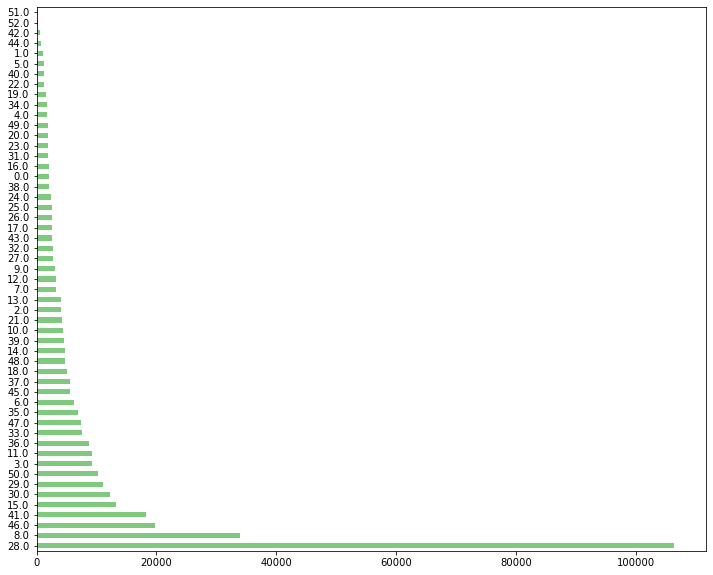

In [9]:
train_eda['Region_Code'].value_counts().plot(kind='barh',cmap='Accent',figsize=(12,10));

* Meaning of these codes has not been provided.
* Most of the data is collected from people living in region with code 28

## Previously-insured

In [10]:
pd.crosstab(train_eda['Response'], train_eda['Previously_Insured'])

Previously_Insured,No,Yes
Response,,
No,159929,174470
Yes,46552,158


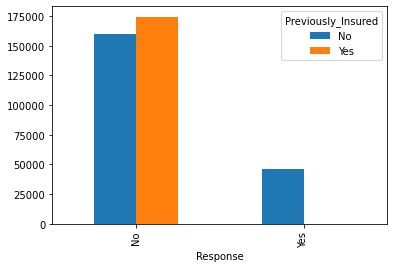

In [11]:
pd.crosstab(train_eda['Response'], train_eda['Previously_Insured']).plot(kind='bar');

* Those who already have an insurance are not interested. This was obvious man!


## Vehicle Age

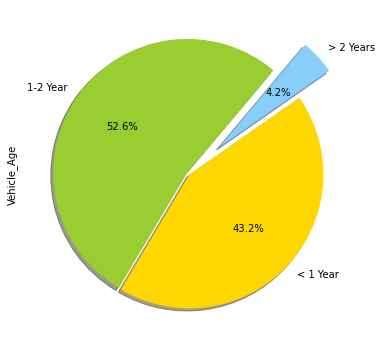

In [12]:
plt.rcParams['figure.figsize']=(6,8)
color = ['yellowgreen','gold',"lightskyblue"]
train_eda['Vehicle_Age'].value_counts().plot.pie(y="Vehicle_Age",colors=color,explode=(0.02,0,0.3),startangle=50,shadow=True,autopct="%0.1f%%")
plt.axis('on');

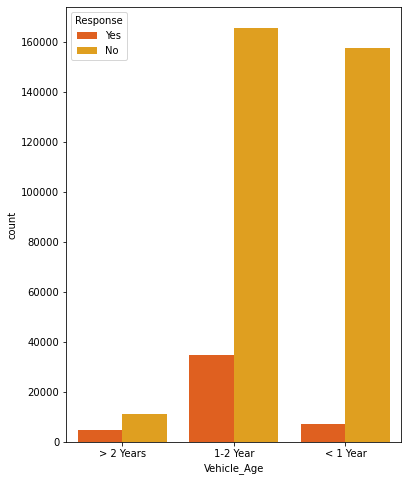

In [13]:
sns.countplot(train_eda['Vehicle_Age'],hue=train_eda['Response'],palette='autumn');

* More than half of the data (52%) has samples with vehicle age between 1-2 years.
* We can't say from second graph that people with vehicle age between 1-2 years are more interested because other category '>2 years' has very few observations.


## Vehicle Damage

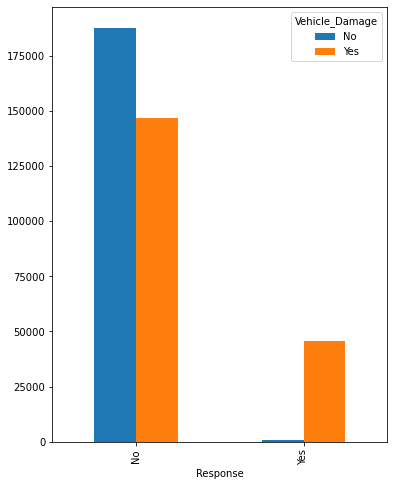

In [14]:
pd.crosstab(train_eda['Response'], train_eda['Vehicle_Damage']).plot(kind='bar');

*  Customers who got his/her vehicle damaged in the past is more likely to be interested in insurance. May be because he has first-hand experience of its pros and cons.
* Ah! I want a version of 'Prevention is better than cure' for this situation.

## Annual Premium

Annual Premium distribution according to Response


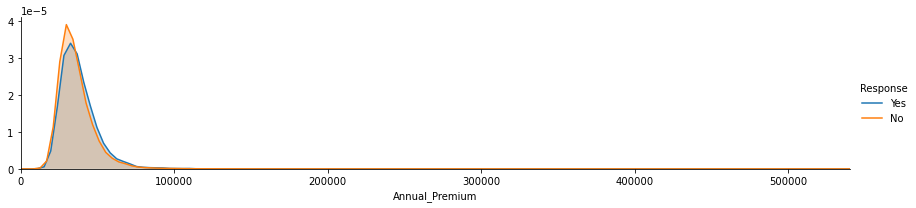

In [15]:
print("Annual Premium distribution according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Annual_Premium",shade = True)
facetgrid.set(xlim = (0,train_eda["Annual_Premium"].max()))
facetgrid.add_legend();

* I don't think it gives much knowledge.
* Outliers can be present in this feature.

## PolicySalesChannel

Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Policy_Sales_Channel distribution according to Response


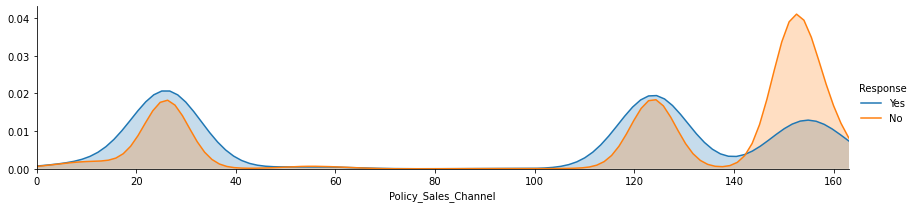

In [16]:
print("Policy_Sales_Channel distribution according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Policy_Sales_Channel",shade = True)
facetgrid.set(xlim = (0,train_eda["Policy_Sales_Channel"].max()))
facetgrid.add_legend();

* This graph seems interesting. But to clearly extract insights we need meaning of these codes.

## Vintage

Number of Days, Customer has been associated with the company

Vintage feature according to Response


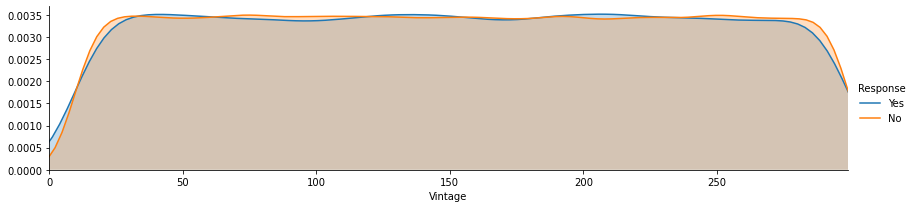

In [17]:
print("Vintage feature according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Vintage",shade = True)
facetgrid.set(xlim = (0,train_eda["Vintage"].max()))
facetgrid.add_legend();

* Our target variable is not much affected by this feature. It can be dropped.

Correlation matrix-


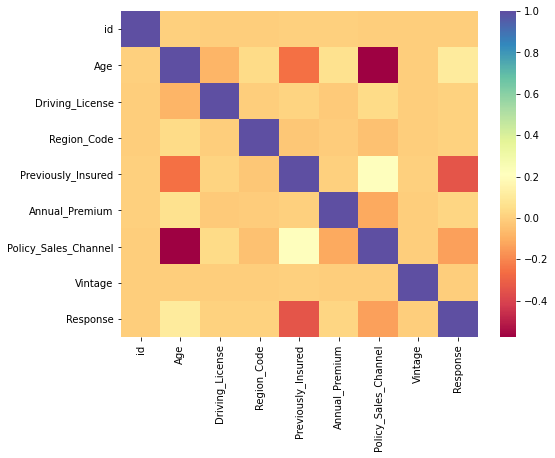

In [18]:
print("Correlation matrix-")
plt.rcParams['figure.figsize']=(8,6)
sns.heatmap(train.corr(),cmap='Spectral');

In [19]:
train.corr()[:-1]['Response'].sort_values().round(2)

Previously_Insured     -0.34
Policy_Sales_Channel   -0.14
id                     -0.00
Vintage                -0.00
Driving_License         0.01
Region_Code             0.01
Annual_Premium          0.02
Age                     0.11
Name: Response, dtype: float64

I will remove least correlated features for modelling.

# Creating classification Model

In [20]:
#creating a checkpoint
df4model = train.copy()
#dropping Vintage column as suggested by EDA
df4model.drop(['id','Vintage'],axis=1,inplace=True)
#checking target variable
df4model.Response.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

To make this data balanced let's upsample the minority class using sklearn library resample.

To prevent any data leakage I will first split into train and test subsets and then do upsampling as suggested by [@antaresnyc](https://www.kaggle.com/antaresnyc).

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df4model.drop(['Response'], axis = 1), 
                                                    df4model['Response'], test_size = 0.2)

In [22]:
print(f"Target variable disribution in train set: \n{y_train.value_counts()}\n\nand in test set: \n{y_test.value_counts()}")

Target variable disribution in train set: 
0    267482
1     37405
Name: Response, dtype: int64

and in test set: 
0    66917
1     9305
Name: Response, dtype: int64


## Up-sampling

In [23]:
#combining train features and target
df = pd.concat([X_train,y_train],axis=1)

from sklearn.utils import resample,shuffle
df_majority = df[df['Response']==0]
df_minority = df[df['Response']==1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=y_train.value_counts()[0],random_state = 123)
balanced_df = pd.concat([df_minority_upsampled,df_majority])
balanced_df = shuffle(balanced_df)
balanced_df.Response.value_counts()

1    267482
0    267482
Name: Response, dtype: int64

Now, I will convert categorical columns into numerical ones.

In [24]:
from sklearn.preprocessing import OrdinalEncoder
encoder= OrdinalEncoder()
cat_cols=['Gender','Vehicle_Damage']
balanced_df[cat_cols] = encoder.fit_transform(balanced_df[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

dummy = pd.get_dummies(balanced_df['Vehicle_Age'],drop_first=True)
features = pd.concat([dummy,balanced_df],axis=1)
features.drop('Vehicle_Age',axis=1,inplace=True)

features.head()

,< 1 Year,> 2 Years,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
345342,1,0,1.0,23,1,16.0,1,0.0,32018.0,152.0,0
262861,1,0,0.0,24,1,10.0,0,1.0,38521.0,152.0,1
97787,0,0,0.0,40,1,8.0,0,1.0,35629.0,124.0,1
371525,0,1,1.0,45,1,15.0,0,1.0,28305.0,124.0,1
318051,0,0,1.0,41,1,28.0,0,1.0,49161.0,30.0,1


In [25]:
#to get uniform output
features = features.astype('float64')
X_train = features.drop('Response',axis=1)
y_train = features['Response']

#creating dummies in test set
dummy1 = pd.get_dummies(X_test['Vehicle_Age'],drop_first=True)
X_test = pd.concat([dummy1,X_test],axis=1)
X_test.drop('Vehicle_Age',axis=1,inplace=True)

# Logistic Regression

In [26]:
logisticRegression = LogisticRegression(max_iter = 10000)
logisticRegression.fit(X_train, y_train)
predictions = logisticRegression.predict(X_test)
print(f"Accuracy score is {100*accuracy_score(y_test,predictions).round(2)}\nROC-AUC score is {100*roc_auc_score(y_test,predictions).round(2)}")

Accuracy score is 63.0
ROC-AUC score is 57.99999999999999


# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(f"Accuracy score is {100*accuracy_score(y_test,rfc_pred).round(2)}\nROC-AUC score is {100*roc_auc_score(y_test,rfc_pred).round(2)}")

Accuracy score is 83.0
ROC-AUC score is 62.0


In [28]:
rfc_preds = rfc.predict_proba(X_test)
print("AUC score after taking probabilities predictions and not classes predictions is")
roc_auc_score(y_test, rfc_preds[:,1], average = 'weighted')

AUC score after taking probabilities predictions and not classes predictions is


0.8109319871962457

In [29]:
X_train.columns= ['less than 1 Year','greater than 2 Years', 'Gender', 'Age','Driving_License',
                  'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium','Policy_Sales_Channel']
X_test.columns= ['less than 1 Year','greater than 2 Years', 'Gender', 'Age','Driving_License',
                  'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium','Policy_Sales_Channel']

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print(f"Accuracy score is {100*accuracy_score(y_test,xgb_pred).round(2)}\nROC-AUC score is {100*roc_auc_score(y_test,xgb_pred).round(2)}")

Accuracy score is 72.0
ROC-AUC score is 80.0


In [30]:
xgb_preds = xgb.predict_proba(X_test)
roc_auc_score(y_test, xgb_preds[:,1], average = 'weighted')

0.85532524564243